# **TLE to State vec [x,y,x] correction NN & ML approach using ILRS data**

## Install and import all required libs & packages

In [88]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
from numpy.linalg import inv
from mpl_toolkits.mplot3d import Axes3D
from datetime import datetime
import pandas as pd
import numpy as np
import os
from scipy.interpolate import Akima1DInterpolator
from jdcal import gcal2jd as date_to_JD
from jdcal import jd2gcal as JD_to_date
import time
import matplotlib
from tletools import TLE
from sklearn.metrics import mean_squared_error
from spacetrack import SpaceTrackClient
import spacetrack.operators as op
import warnings
from sgp4.api import days2mdhms,jday,Satrec
from sgp4.api import WGS84
from astropy.time import Time
import julian
from tqdm import tqdm
import skyfield.sgp4lib as sgp4lib
from skyfield.api import load
from skyfield.framelib import itrs
from astropy import coordinates as coord, units as u
warnings.filterwarnings("ignore")

## **MAIN USEFUL FUNCTIONS TO TRANSFORM TIME AND STATE VECS**

In [86]:
names = ['index', 'name', 'norad', 'classification', 'int_desig', 'epoch_year',
        'epoch_day', 'dn_o2', 'ddn_o6', 'bstar', 'set_num', 'inc', 'raan',
        'ecc', 'argp', 'M', 'n', 'rev_num']
ts = load.timescale()
def astropy_to_skyfield_time(iso_time):
    t_iso = ts.from_astropy(iso_time)
    return t_iso
def epoch_to_data(epoch_year,epoch_day):
    month, day, hour, minute, second = days2mdhms(int(epoch_year), float(epoch_day))
    return int(epoch_year), month, day, hour, minute, second
def date_to_jd(year,month, day, hour, minute, second):
    ts = load.timescale()
    time_jd = (ts.utc(year, month, day, hour, minute, second)).to_astropy()
    return time_jd
def jd_to_mjd(jd_t):
    try: mjd_t = jd_t.to_value('mjd')
    except: mjd_t = Time(Time((jd_t), format='jd')).to_value('mjd')
    return mjd_t
def mjd_to_jd(mjd_t):
    try: jd_t = mjd_t.to_value('jd')
    except: jd_t = Time(Time((mjd_t), format='mjd')).to_value('jd')
    return jd_t
def iso_to_jd(t_utc):
    try:jd_t = (t_utc).to_value('jd')
    except:jd_t =Time(Time((t_utc), format='iso')).to_value('jd')
    return jd_t
def jd_to_iso(jd_time):
    try:tm = Time(Time((jd_time), format='jd').to_value('iso'))
    except:tm = Time(Time((jd_time), format='jd').to_value('iso'))
    return tm
def mjd_to_iso(mjd_time):
    tm = Time(Time((mjd_time), format='mjd').to_value('iso'))
    return tm
def tle_epoch_to_mjd(epoch_year,epoch_day):
    year,month, day, hour, minute, second = epoch_to_data(epoch_year,epoch_day)
    jd_date = date_to_jd(year,month, day, hour, minute, second)
    mjd_date = jd_to_mjd(jd_date)
    return mjd_date
def timestamp_from_datetime(t):
    delta, JD = date_to_JD(t.year, t.month, t.day)
    seconds = t.microsecond / 1e6 + t.second + 60*t.minute + 3600*t.hour
    return int(JD) + seconds / 86400
def parse_CPF(raw_data):
    data = {}
    data["name"] = None
    data["start"] = None
    data["end"] = None
    data["predictions"] = []
    for line in raw_data.split("\n"):
        if line.startswith("H1") or line.startswith("h1"):
            data["name"] = line[35:45]
        elif line.startswith("H2") or line.startswith("h2"):
            data["start"] = datetime(
                year = int(line[26:30]),
                month = int(line[31:33]),
                day = int(line[34:36]),
                hour = int(line[37:39]),
                minute = int(line[40:42]),
                second = int(line[43:45])
            )
            data["end"] = datetime(
                year = int(line[46:50]),
                month = int(line[51:53]),
                day = int(line[54:56]),
                hour = int(line[57:59]),
                minute = int(line[60:62]),
                second = int(line[63:65])
            )
        elif line.startswith("10"):
            sline = [float(x) for x in line.split()]
            t = sline[2] + sline[3] / 86400
            data["predictions"].append((t, sline[5:8]))
    data_df = pd.DataFrame(data)
    predictions = np.array(data_df["predictions"].values)
    mjds = np.array([predictions[i][0] for i in range(len(predictions))])
    coords = np.array([predictions[i][1] for i in range(len(predictions))])
    data_df['x_itrf'],data_df['y_itrf'],data_df['z_itrf'] =coords.T/1000# from m to km
    data_df['mjd'] = mjds
    jds = [mjd_to_jd(mjds[i]) for i in range(len(mjds))]
    data_df['jd'] = jds
    r_itrf = coords/1000
    iso_time = [jd_to_iso(jds[i]) for i in range(len(data_df))]
    rot_mats = [ITRS_to_J2000_matrix(iso_time[i]) for i in range(len(data_df))]
    r_j000 = np.array([np.dot(rot_mats[i],r_itrf[i]) for i in range(len(data_df))])
    data_df['x_j2000'],data_df['y_j2000'],data_df['z_j2000'] =r_j000.T
    df_reduced = data_df[['name','mjd','jd','x_itrf','y_itrf','z_itrf','x_j2000','y_j2000','z_j2000']]
    print(data["start"],data["end"])
    return df_reduced,data
def TEME_to_ITRS(r,v,jd_time):
    r_itrf,v_itrf= sgp4lib.TEME_to_ITRF(jd_time.to_value('jd'),np.asarray(r),np.asarray(v)*86400)
    v_itrf=v_itrf/86400
    return r_itrf,v_itrf
def ITRS_to_J2000_matrix(iso_time):
    gcrs2itrs_mat = framelib.itrs.rotation_at(astropy_to_skyfield_time(iso_time))
    itrs2gcrs_mat = inv(gcrs2itrs_mat)
    return itrs2gcrs_mat
def ITRS_to_J2000(r_itrf,v_itrf,jd_time):
    # Conversion from ITRS to J2000
    itrs = coord.ITRS(r_itrf[0]*u.km, r_itrf[1]*u.km, r_itrf[2]*u.km, v_itrf[0]*u.km/u.s, v_itrf[1]*u.km/u.s, v_itrf[2]*u.km/u.s, obstime=jd_to_iso(jd_time))
    gcrs = itrs.transform_to(coord.GCRS(obstime=jd_to_iso(jd_time)))
    r_j200,v_j2000=gcrs.cartesian.xyz.value,gcrs.velocity.d_xyz.value
    return r_j200,v_j2000
def make_line1(tle_df_row):
    s = '1 '+str(tle_df_row[2])+str(tle_df_row[3])
    for i in range(7):
        s=s+' '+str(tle_df_row[i+4])
    return s
def make_line2(tle_df_row):
    t= '2 '+str(tle_df_row[2])
    for i in range(6):
        t=t+' '+str(tle_df_row[i+11])
    return t
def tle_to_coords(sat_name,tle_df_row1,tle_df_row2,columns = names):
    splited_line1 = tle_df_row1.split()
    splited_line2 = tle_df_row2.split()
    epoch_year,epoch_day = splited_line1[3][:2], splited_line1[3][2:]
    year,month, day, hour, minute, second = epoch_to_data(epoch_year,epoch_day)
    year = int('20'+str(year))
    date_utc = [year,month, day, hour, minute, second]
    #print(year,month, day, hour, minute, second)
    jd, fr = jday(year,month, day, hour, minute, second)
    jd_time = jd+fr
    iso_time = jd_to_iso(jd_time)
    s = tle_df_row1[:-1]
    t = tle_df_row2[:-1]
    satellite = Satrec.twoline2rv(s, t, WGS84)
    e, r_teme, v_teme = satellite.sgp4(jd, fr)
    #skyfield realization of getting position from tle data
    ts = load.timescale()
    tt = ts.utc(year,month, day, hour, minute, second)
    sat = EarthSatellite(s, t, sat_name[:-1], ts)
    geocentric = sat.at(tt)
    geocentric_coords = geocentric.position.km
    return np.array(e), np.array(r_teme), np.array(v_teme),iso_time,geocentric_coords


### **FUNCTION FOR PARSING SPACETRACK.ORG ANG SAVE TLE DATA FROM THIS SOURCE**

### You can skip next 2 code cells & altenatively use one of the 4 satellites from this repo!

In [90]:
# def get_tle_from_spacetrack(id_sat,start,end,sat_name, tle_dir):
#     login = # ENTER YOUR SPACETRACK.ORG REGISTRATION E-MAIL HERE
#     pswd = # ENTER YOUR SPACETRACK.ORG REGISTRATION PASSWORD HERE

#     st = SpaceTrackClient(login, pswd)
#     decay_epoch = op.inclusive_range(start, end)
#     tle_data = st.tle(norad_cat_id=[id_sat], format='tle', epoch=decay_epoch)
#     sat_name_for_csv = sat_name+'\n'
#     if not os.path.exists(tle_dir):
#         os.makedirs(tle_dir)
#     with open(tle_dir, "w") as text_file: #earth_sats_names_from_celestrak
#         text_file.write(tle_data)
#     ##########################################################################################
#     with open(tle_dir) as f:
#         lines = f.readlines()
#     for i in range(0,int(len(lines)*3/2)-1,3):
#         lines.insert(i, sat_name_for_csv)
#         d= {'name':0,
#     'norad':0, 'classification':0, 'int_desig':0, 'epoch_year':0, 'epoch_day':0, 'dn_o2':0, 'ddn_o6':0, 'bstar':0, 'set_num':0, 'inc':0, 'raan':0, 'ecc':0, 'argp':0,
#         'M':0, 'n':0, 'rev_num':0}
#     t = pd.DataFrame(d, index=[0])
#     tle_string = lines[0:3]
#     tle_string = tle_string[0]+tle_string[1]+tle_string[2]
#     tle_lines = tle_string.strip().splitlines()
#     tle = TLE.from_lines(*tle_lines)
#     for i in range(0,len(lines),3):
#         tle_string = lines[i:i+3]
#         tle_string = tle_string[0]+tle_string[1]+tle_string[2]
#         tle_lines = tle_string.strip().splitlines()
#         tle = TLE.from_lines(*tle_lines)
#         d= {'name':tle.name,
#         'norad':tle.norad, 'classification':tle.classification, 'int_desig':tle.int_desig,
#             'epoch_year':tle.epoch_year, 'epoch_day':tle.epoch_day, 'dn_o2':tle.dn_o2, 'ddn_o6':tle.ddn_o6,
#             'bstar':tle.bstar, 'set_num':tle.set_num, 'inc':tle.inc, 'raan':tle.raan, 'ecc':tle.ecc, 'argp':tle.argp,
#         'M':tle.M, 'n':tle.n, 'rev_num':tle.rev_num}
#         cols = d.keys()
#         vals = d.values()
#         t = t.append(dict(zip(cols, vals)), ignore_index=True)
#     tle_df= t.iloc[1::].reset_index()
#     tle_df.to_csv(dir.replace('txt','csv'))
#     return lines,tle_df
# def df_j2000_from_TLE(tle_strings, satname, sat_id):
#     e, r_teme, v_teme,iso_time,geocentric_coords = tle_to_coords(tle_strings[0],tle_strings[1],tle_strings[2])
#     d = {'name' :satname,'norad_id':sat_id,'mjd_t':jd_to_mjd(iso_to_jd(iso_time)),'jd_t':iso_to_jd(iso_time),
#          'x_j2000_tle':geocentric_coords[0],
#          'y_j2000_tle':geocentric_coords[1],'z_j2000_tle':geocentric_coords[2]}
#     cols = d.keys()
#     vals = d.values()
#     j2000_coords_from_TLE = pd.DataFrame(dict(zip(cols, vals)),index =[0])
#     for i in tqdm(range(3,len(tle_strings),3)):
#         sat_name,tle_df_row1,tle_df_row2 = tle_strings[i],tle_strings[1+i],tle_strings[2+i]
#         e, r_teme, v_teme,iso_time, geocentric_coords = tle_to_coords(sat_name,tle_df_row1,tle_df_row2)
#         x_j2000,y_j2000,z_j2000 = geocentric_coords
#         d ={'name' :satname,'norad_id':sat_id,'mjd_t':jd_to_mjd(iso_to_jd(iso_time)),'jd_t':iso_to_jd(iso_time),
#             'x_j2000_tle':geocentric_coords[0],
#          'y_j2000_tle':geocentric_coords[1],'z_j2000_tle':geocentric_coords[2]}
#         cols = d.keys()
#         vals = d.values()
#         j2000_coords_from_TLE = j2000_coords_from_TLE.append(dict(zip(cols, vals)), ignore_index=True)
#     return j2000_coords_from_TLE

### **INPUT NORAD ID of satelite and its name, start and end dates & get TLE for a given time period from spacetrack.org**

### You can skip next cell & altenatively use one of the 4 satellites from this repo!

In [ ]:
# id_sat_tandemx,start,end,sat_name_tandemx = 41105,'2022-10-15','2022-10-16','tandemx'
# id_sat_terrasarx,sat_name_terrasarx = 31698,'terrasarx'
# id_sat_technosat,sat_name_technosat = 42829,'technosat'
# id_sat_glonass,sat_name_glonass = 32276,'glonass_105'
# ids_sat = [id_sat_tandemx,id_sat_technosat,id_sat_terrasarx]
# j2000_coords_from_TLEs = []
# sat_names = ['tandemx','technosat','terrasarx', 'glonass']
# for i in range(len(sat_names)):
#     dir_tle = 'tle/'+sat_names[i]+'_df_TLE_2021_2022.txt'
#     tle_strings,tle_df = get_tle_from_spacetrack(ids_sat[i],start,end,sat_names[i],dir_tle)
#     j2000_coords_from_TLE = df_j2000_from_TLE(tle_strings,sat_names[i], ids_sat[i])
#     j2000_coords_from_TLEs.append(j2000_coords_from_TLE)

## **NOW GO TO PYTORCH AND NN INITALIZATION**

### **IMPORT PYTORCH AND ITS UTILS PACKAGES**

In [93]:
import random
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import random_split

In [94]:
def set_random_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
set_random_seed(42)

**SEVERAL VALUES OF ILRS COPORDS WERE INTERPOLATED TOO BADLY! NEED TO IDENTIFY AND DROP THEM ALL FROM DATASET!!!**

In [95]:
df_dir = 'tle/matched_glonass105_TLE_ILRS_2020_2022.csv'
df_TLE_dir= 'tle/full_glonass105_df_TLE_2020_2022.csv'
df_tle_ilrs = pd.read_csv(df_dir)
df_TLE = pd.read_csv(df_TLE_dir)
needed_columns = ['epoch_year', 'epoch_day', 'dn_o2', 'ddn_o6', 'bstar', 'inc',
        'raan', 'ecc', 'argp', 'M', 'n', 'rev_num']
dataset_df = df_TLE[needed_columns]
ilrs_coords = df_tle_ilrs[['x_j2000_ilrs_Akima','y_j2000_ilrs_Akima','z_j2000_ilrs_Akima']]
sgp4_coords = df_tle_ilrs[['x_j2000_tle','y_j2000_tle','z_j2000_tle']]
delta_x = sgp4_coords['x_j2000_tle'].values - ilrs_coords['x_j2000_ilrs_Akima'].values
delta_y = sgp4_coords['y_j2000_tle'].values - ilrs_coords['y_j2000_ilrs_Akima'].values
delta_z = sgp4_coords['z_j2000_tle'].values - ilrs_coords['z_j2000_ilrs_Akima'].values

####### REMOVE BAD INTERPOLATIONS
delta_coords = sgp4_coords.values-ilrs_coords.values
#append deltas to ilrs df
ilrs_coords['delta_x'] = delta_x
ilrs_coords['delta_y'] = delta_y
ilrs_coords['delta_z'] = delta_z
bad_interpolations = []
for i in range(len(delta_coords)):
    if np.linalg.norm(delta_coords[i])>10:
        bad_interpolations.append(i)
print('bad_interpolations indices',len(bad_interpolations),bad_interpolations)
##### DROP THIS ODD VALUES FROM DF
dataset_df = dataset_df.drop(index = bad_interpolations).reset_index().drop(columns = ['index'])
ilrs_coords = ilrs_coords.drop(index = bad_interpolations).reset_index().drop(columns = ['index'])
sgp4_coords = sgp4_coords.drop(index = bad_interpolations).reset_index().drop(columns = ['index'])
df_tle_ilrs = df_tle_ilrs.drop(index = bad_interpolations).reset_index().drop(columns = ['index'])
print(dataset_df.head(), ilrs_coords.head())
dataset = []
for i in range(len(dataset_df)):
    tle_seq = torch.tensor(dataset_df.iloc[i].values, dtype=torch.float32)
    xyz_ilrs = torch.tensor(ilrs_coords.iloc[i].values, dtype=torch.float32)
    xyz_sgp4 = torch.tensor(sgp4_coords.iloc[i].values, dtype=torch.float32)
    sample = (tle_seq, xyz_sgp4, xyz_ilrs)
    dataset.append(sample)
tle_0, xyz_0_sgp4, xyz_ilrs = dataset[0]
print('dataset sample:',tle_0, xyz_0_sgp4, xyz_ilrs)

bad_interpolations indices 51 [0, 1, 2, 3, 4, 5, 53, 54, 55, 56, 57, 58, 59, 61, 62, 76, 77, 78, 79, 80, 81, 82, 83, 111, 112, 113, 114, 115, 116, 117, 119, 120, 121, 365, 367, 368, 369, 398, 400, 401, 403, 404, 405, 406, 407, 1723, 1724, 1725, 1726, 2121, 2122]
   epoch_year  epoch_day         dn_o2  ddn_o6   bstar      inc     raan  \
0        2020   6.160877 -2.200000e-07     0.0  0.0001  65.9401  34.4494   
1        2020   6.622151 -1.900000e-07     0.0  0.0001  65.9404  34.4343   
2        2020   7.585895 -1.500000e-07     0.0  0.0001  65.9409  34.4022   
3        2020   8.638364 -1.200000e-07     0.0  0.0001  65.9413  34.3671   
4        2020   9.554474 -1.100000e-07     0.0  0.0001  65.9415  34.3368   

        ecc      argp         M         n  rev_num  
0  0.001117  317.8469   28.2875  2.131036     9492  
1  0.001125  317.9151   22.0941  2.131036     9493  
2  0.001128  317.8695   41.4924  2.131036     9495  
3  0.001130  317.8168  128.9637  2.131036     9498  
4  0.001134  31

### MAKE TRAIN-VAL-TEST SPLIT OF DATASET

In [96]:
trainset, valset, testset  = random_split(dataset, [0.75, 0.15, 0.1])
batch_size = 256
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(valset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(testset, batch_size=batch_size+3, shuffle=False)
print(trainset[0])

(tensor([ 2.0210e+03,  2.5075e+02, -5.1000e-07,  0.0000e+00,  0.0000e+00,
         6.6086e+01,  1.4150e+01,  7.6250e-04,  3.3241e+02,  7.5800e+01,
         2.1310e+00,  1.0794e+04]), tensor([14658.1201, 11552.7666, 17373.3301]), tensor([ 1.4660e+04,  1.1554e+04,  1.7374e+04, -1.7763e+00, -9.1730e-01,
        -4.0698e-01]))


**LETS NORMILIZE ALL DATA TO MAKE IT EASIER FOR NN TO WORK WITH**

In [97]:
#normalization
def normalize(data, mean, std):
    eps = 1e-8
    return (data - mean) / (std+eps)
def unnormalize(data, mean, std):
    return data * std + mean
print(ilrs_coords.head())

   x_j2000_ilrs_Akima  y_j2000_ilrs_Akima  z_j2000_ilrs_Akima   delta_x  \
0        21851.494877        11849.020362        -5615.669716  1.167873   
1        21790.177778        10513.965494        -8001.554493  0.959461   
2        21149.884478        14217.351944         -289.872462  2.153208   
3        -4628.277816         9389.517626        23274.468488  6.267312   
4         1908.445371        13048.299185        21840.287990  6.817662   

    delta_y   delta_z  
0 -1.344165 -3.954652  
1  0.327136 -0.890922  
2 -1.331877 -2.276653  
3  3.243213 -1.388498  
4  2.887789 -2.936332  


In [98]:
#merge xyz_sgp4_to TLE df for new model training
modified_dataset = np.array([(torch.cat([dataset[i][0],dataset[i][1]], dim =0), dataset[i][-1]) for i in range(len(dataset))])
X = np.array([np.array(torch.cat([dataset[i][0],dataset[i][1]], dim =0)) for i in range(len(dataset))])
Y = np.array([np.array(dataset[i][-1]) for i in range(len(dataset))])
mean_x, mean_y = np.mean(X, axis=0), np.mean(Y, axis=0)
std_x, std_y = np.std(X, axis=0), np.std(Y, axis=0)
print('mean are:',mean_x, mean_y)
print('std are:',std_x, std_y)
X_norm, Y_norm = normalize(X,mean_x, std_x), normalize(Y,mean_y, std_y)
modified_dataset_norm = np.array([np.array([X_norm[i], Y_norm[i]]) for i in range(len(dataset))])

mean are: [ 2.0210496e+03  1.8729007e+02 -5.8448717e-07  0.0000000e+00
  2.3905421e-05  6.6058983e+01  3.3043598e+01  1.0103233e-03
  3.2742889e+02  1.7203363e+02  2.1310296e+00  1.0696416e+04
  8.6822632e+02 -2.2714659e+02 -2.4946027e+02] [ 8.6800989e+02 -2.2731122e+02 -2.4957674e+02  2.1571243e-01
  1.6442400e-01  1.1603964e-01]
std are: [7.9527903e-01 1.0740616e+02 1.8034793e-07 0.0000000e+00 4.2650270e-05
 4.2868149e-02 7.4013176e+01 1.6495926e-04 9.6445818e+00 1.0681384e+02
 5.7362417e-06 6.4492865e+02 1.8472531e+04 8.5588672e+03 1.5340189e+04] [1.8472650e+04 8.5590586e+03 1.5340269e+04 2.1859369e+00 1.4005479e+00
 2.3742263e+00]


In [99]:
modified_dataset_norm_list = []
for i in range(len(modified_dataset_norm)):
    modified_dataset_norm[i][0] = torch.tensor(modified_dataset_norm[i][0],dtype = torch.float32)#.item()
    modified_dataset_norm[i][1] = torch.tensor(modified_dataset_norm[i][1],dtype = torch.float32)#.item()
    modified_dataset_norm_list.append((torch.tensor(modified_dataset_norm[i][0],dtype = torch.float32),torch.tensor(modified_dataset_norm[i][1],dtype = torch.float32)))
trainset, valset, testset  = random_split(modified_dataset_norm_list, [0.75, 0.15, 0.1])
batch_size = 256
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(valset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(testset, batch_size=batch_size+3, shuffle=False)
x,y = trainset[0]

(tensor([ 1.1951,  1.3337,  0.7591,  0.0000, -0.5604,  0.5905,  4.4094,  0.0344,
         -1.4800, -1.2178,  0.8298,  1.6197,  1.3268, -0.1218, -0.1163]),
 tensor([ 1.3267, -0.1218, -0.1162,  0.5120,  0.1521, -0.8025]))

In [100]:
class FC_tiny(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(15, 12)
        self.fc2 = nn.Linear(12, 8)
        self.fc3 = nn.Linear(8, 4)
        self.bn = nn.BatchNorm1d(12)
        self.fc4 = nn.Linear(4, 3)
        self.activation = nn.ReLU()

    def forward(self, x): 
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        x = self.activation(x)
        x = self.fc3(x)
        x = self.activation(x)
        x = self.fc4(x)
        return x

In [101]:
def train_sgp4_to_ilrs(model, train_loader, val_loader, criterion, optimizer, cur_ep=0, num_epochs=1000, bs=100):
    train_losses,val_losses, tle_ilrs_losses = [],[],[]
    model.cuda()
    for epoch in tqdm(range(num_epochs)):
        if epoch%500 == 0:
            print('epoch =',epoch+1)
        total, ep_loss, val_loss, tle_ilrs_loss = 0, 0, 0, 0
        for tle, vec_state  in train_loader:
            ilrs, delta_r = vec_state[:,:3], vec_state[:,3:]
            tle, ilrs, delta_r = tle.cuda(), ilrs.cuda(),delta_r.cuda()
            optimizer.zero_grad()
            outputs = model(tle)
            loss = criterion(outputs, delta_r)
            loss.backward()
            optimizer.step()
            total += vec_state.size(0)
            ep_loss += loss.item()
        train_losses.append(ep_loss/bs)
        with torch.no_grad():
            for tle, vec_state in val_loader:
                ilrs, delta_r = vec_state[:,:3], vec_state[:,3:]
                tle, ilrs, delta_r = tle.cuda(), ilrs.cuda(),delta_r.cuda()
                outputs = model(tle)
                loss = criterion(outputs, delta_r)
                val_loss = loss.item() + val_loss
            val_losses.append(val_loss/bs)#cpu().detach().numpy()
    model_name = 'models/tiny_model_'+str(cur_ep+epoch+1)
    torch.save(model.state_dict(),model_name)
    print('############## model saved after training! ###############')
    return train_losses,val_losses

  0%|▍                                                                                | 5/1000 [00:00<00:22, 43.50it/s]

epoch = 1


 51%|███████████████████████████████████████▉                                       | 506/1000 [00:11<00:11, 44.00it/s]

epoch = 501


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:23<00:00, 43.00it/s]


############## model saved after training! ###############


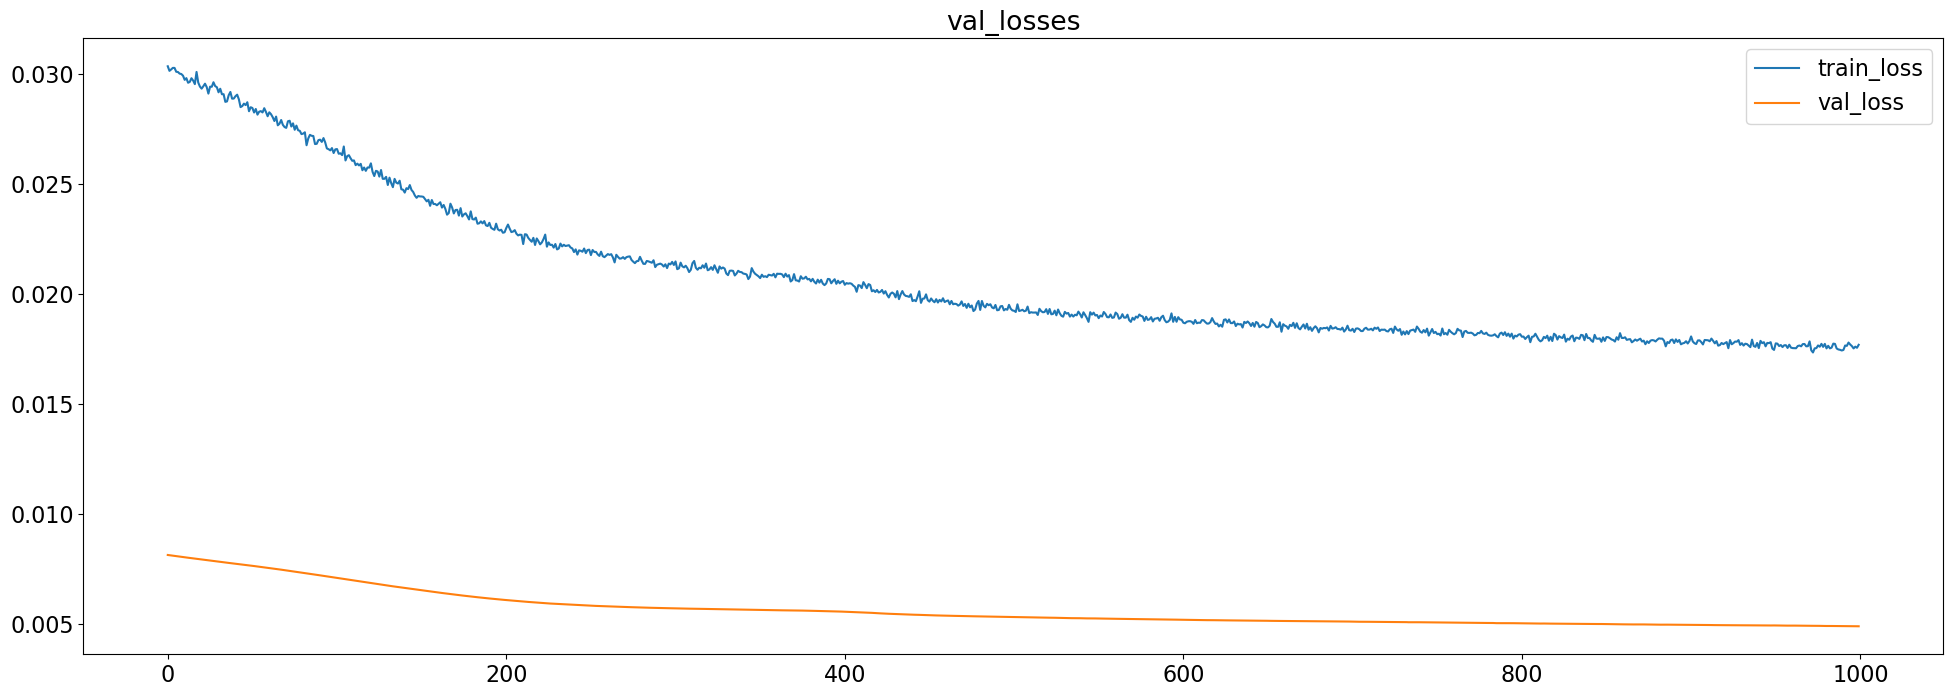

In [102]:
######## INITIALIZE OUT TINY FC MODEL ############
model_sgp2ilrs = FC_tiny()
lr = 1e-4
optimizer = torch.optim.AdamW(model_sgp2ilrs.parameters(), lr= lr)
num_epochs = 1000
cur_ep = 0
model_sgp2ilrs.train()
train_losses,val_losses = train_sgp4_to_ilrs(model_sgp2ilrs,train_loader, val_loader, criterion, optimizer,cur_ep=cur_ep, num_epochs=num_epochs, bs = batch_size)
fig, ax = plt.subplots(1,1, figsize = (24,8))
ax.plot(np.arange(num_epochs),train_losses, label = 'train_loss')
ax.plot(np.arange(num_epochs),val_losses, label = 'val_loss')
ax.set_title('train_losses')
ax.set_title('val_losses')
plt.legend()
plt.show()

### **TESTING SGP4 to ILRS STATE VEC CORRECTION ON TEST DATA**

In [103]:
criterion =  torch.nn.MSELoss()
# model_dir = 'models/tiny_model_1000'
# model_sgp2ilrs.load_state_dict(torch.load(model_dir))
model_sgp2ilrs.eval().cuda()
mean_sgp4, std_sgp4 = mean_x[-3:], std_x[-3:]
mean_delta, std_delta = mean_y[-3:], std_y[-3:]

for tle, vec_state  in test_loader:
    ilrs, delta_r = vec_state[:,:3], vec_state[:,3:]
    tle = tle.cuda()
    sgp4_xyz = tle[:,-3:]
    sgp4_xyz = unnormalize(sgp4_xyz.cpu().detach().numpy(), mean_sgp4, std_sgp4)
    outputs = model_sgp2ilrs(tle).cpu().detach().numpy()
    outputs_inv = unnormalize(outputs, mean_delta, std_delta)
    ilrs_xyz_inv = unnormalize(vec_state.cpu().detach().numpy(), mean_y, std_y)
    deltas = ilrs_xyz_inv[:,-3:]

    print('rmse = ',np.sqrt(criterion(torch.tensor(deltas), torch.tensor(outputs_inv)).item()))
    print('real rmse = ',np.sqrt(criterion(torch.tensor(sgp4_xyz), torch.tensor(ilrs_xyz_inv[:,:3])).item()))

rmse =  1.6818335729264966
real rmse =  2.088449059111489


## **Try classic ML models like RandomForest as well to compare it with MLP**

In [104]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [106]:
X_test, Y_test, X_tr, Y_tr, d_test  = [],[],[],[],[]
for sample in trainset:
    x, y  = sample[0].numpy(),sample[1].numpy()
    X_tr.append(x)
    Y_tr.append(y)
for sample in testset:
    x, y  = sample[0].numpy(),sample[1].numpy()
    X_test.append(x)
    Y_test.append(y)
Y_test = unnormalize(np.array(Y_test), mean_y, std_y)
Y_tr = unnormalize(np.array(Y_tr), mean_y, std_y)
tr_ilrs, tr_delta_r = Y_tr[:,:3], Y_tr[:,3:]
test_ilrs, test_delta_r = Y_test[:,:3], Y_test[:,3:]
test_sgp4_xyz = np.array(X_test)[:,-3:]
test_sgp4_xyz = unnormalize(test_sgp4_xyz, mean_sgp4, std_sgp4)

### initialize RandomForest, fit it and predict on tets data

In [107]:
rf = RandomForestRegressor(n_estimators = 500, n_jobs=-1)
rf = rf.fit(X_tr, tr_delta_r)
y_pred = rf.predict(X_test)

### Compare the results of RandomForest with SGP4

In [109]:
corrected_xyz_rf = test_sgp4_xyz-y_pred
rmse = np.sqrt(criterion(torch.tensor(corrected_xyz_rf), torch.tensor(test_ilrs)).item())
real_rmse = np.sqrt(criterion(torch.tensor(test_sgp4_xyz), torch.tensor(test_ilrs)))
print('rmse =',rmse, '\nreal rmse', real_rmse)

rmse = 1.3001789280535798 
real rmse tensor(2.0884)


## **COMPARISON RF VS FC MODELS ON THE SAME TEST DATA OF satellites**

### **LETS VISUALIZE IT IN THE CRS, WHERE THE (0,0,0) is ILRS TRUE STATE VEC**

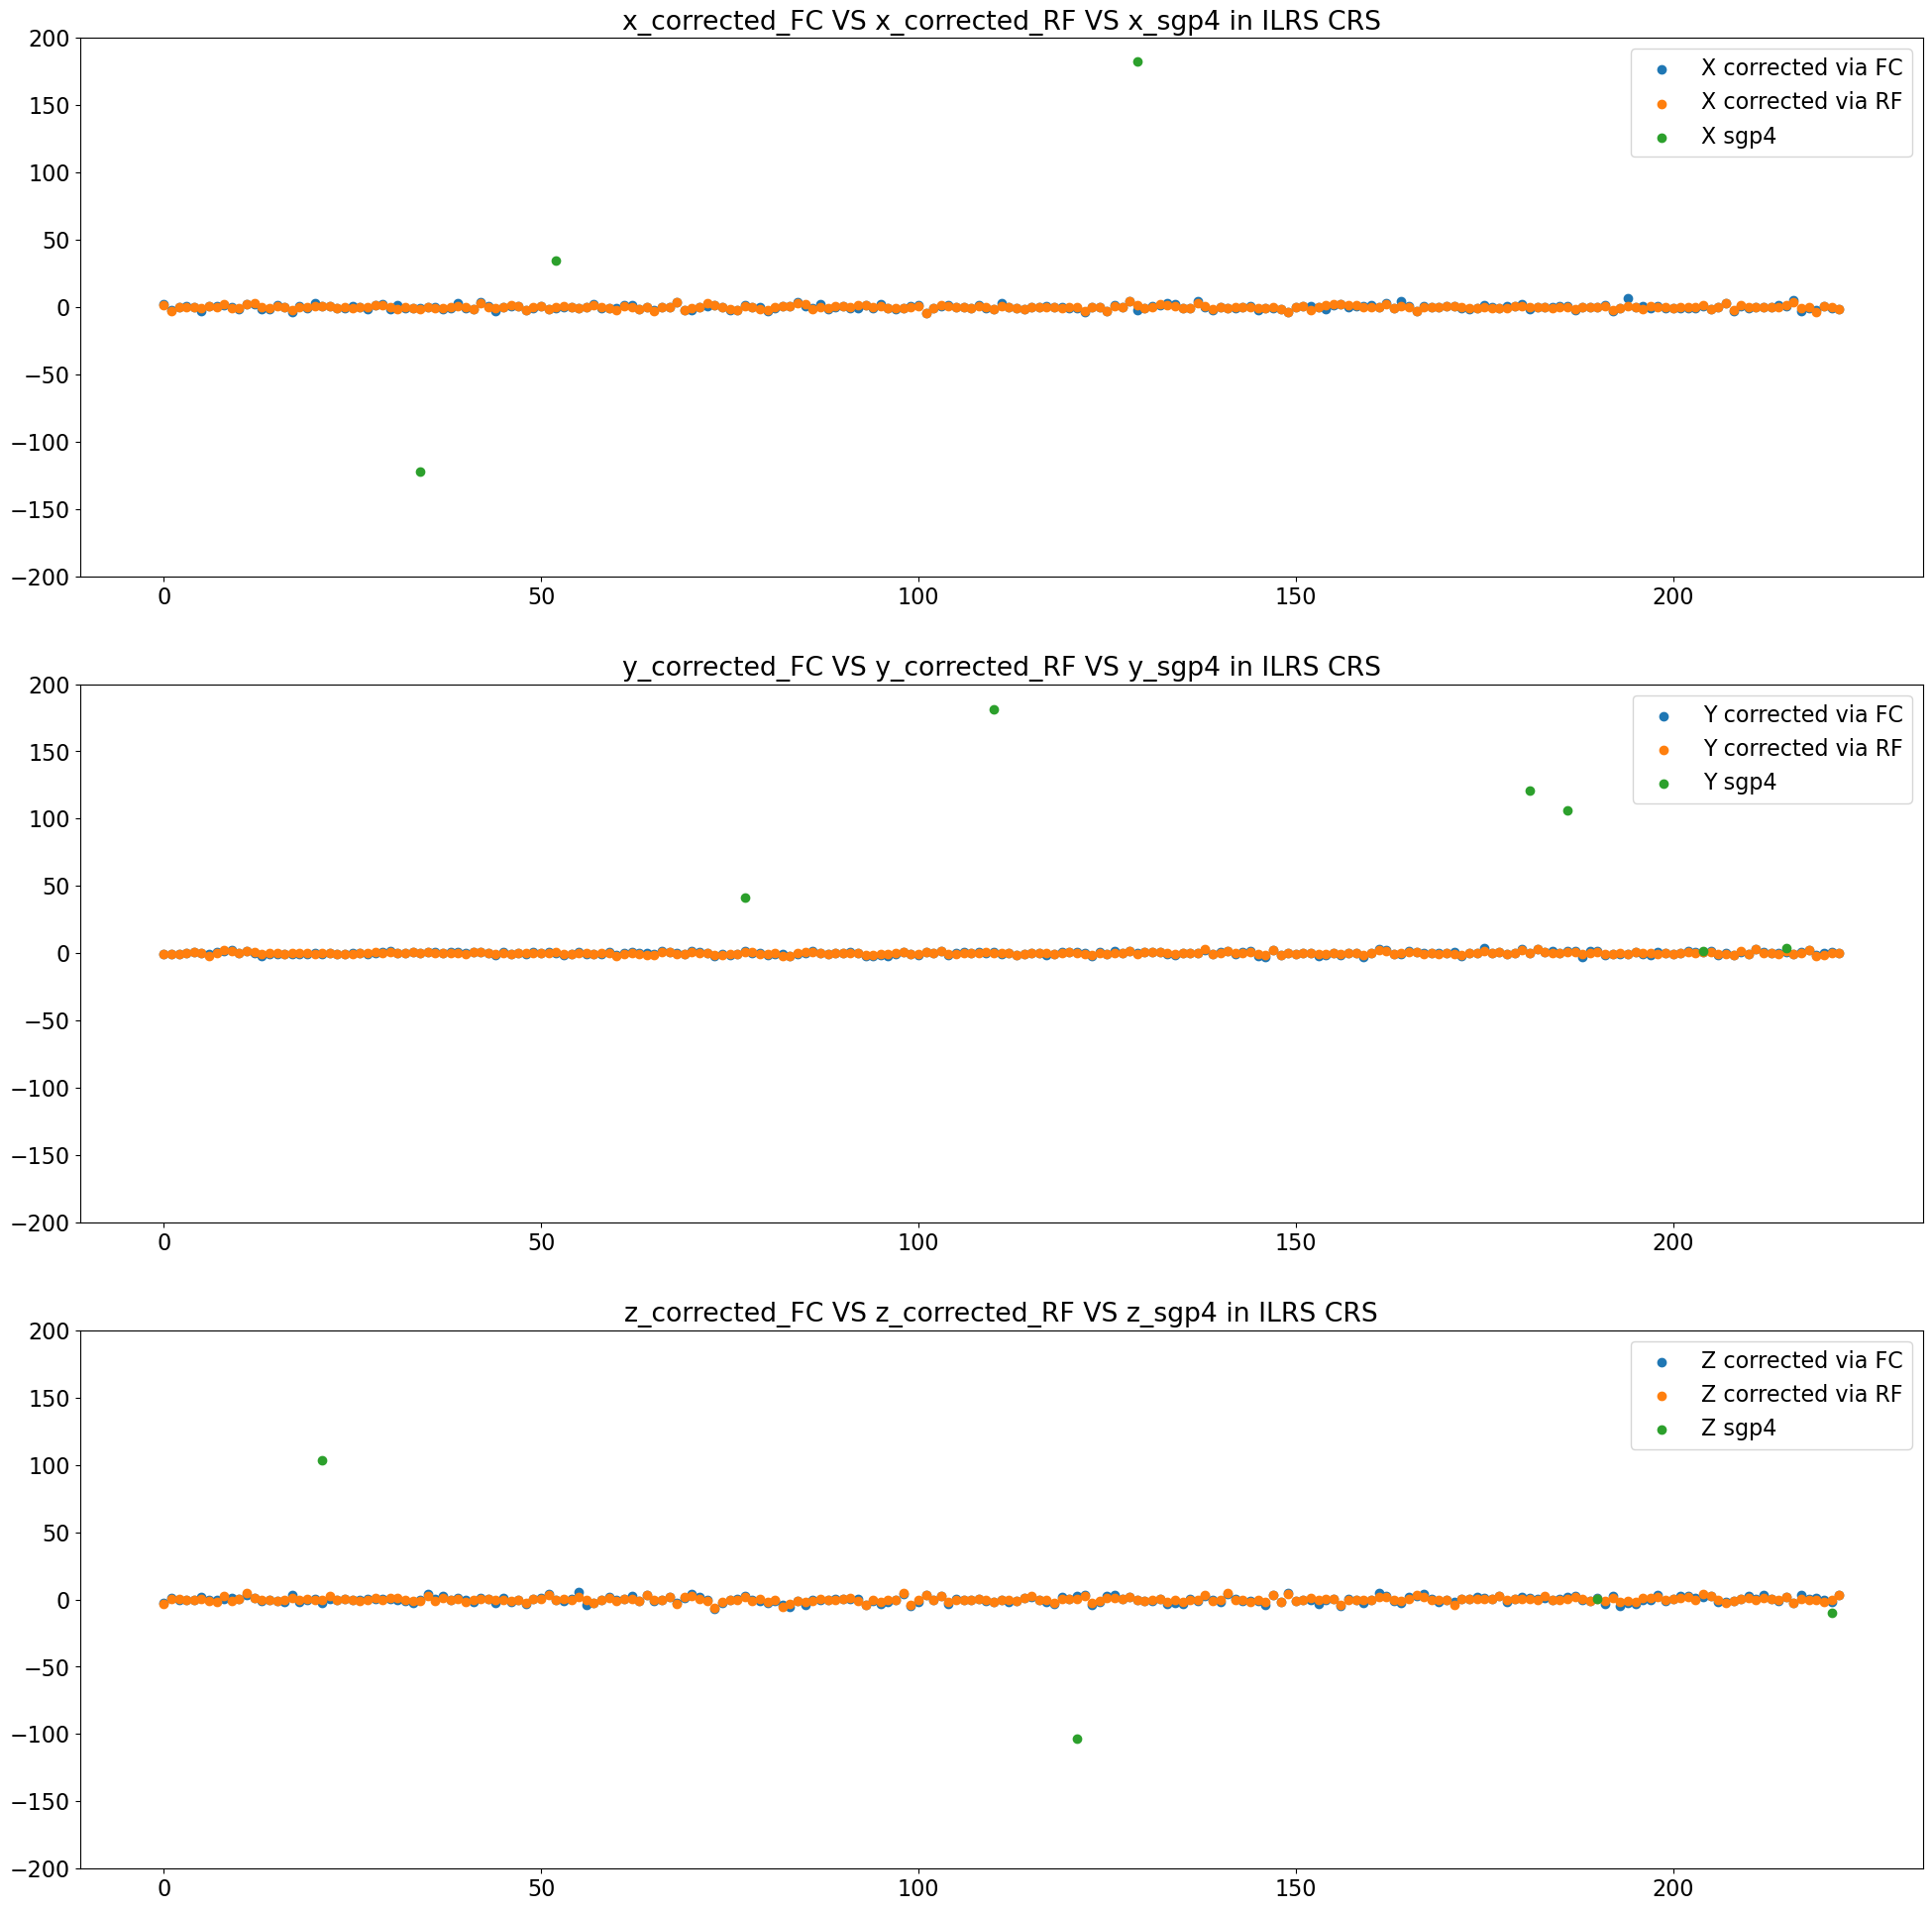

In [110]:
corrected_xyz = sgp4_xyz-outputs_inv
corrected_xyz_ilrs_csr = corrected_xyz-ilrs_xyz_inv[:,:3]
corrected_xyz_rf_ilrs_csr = corrected_xyz_rf-ilrs_xyz_inv[:,:3]
corrected_x_ilrs_csr,corrected_y_ilrs_csr,corrected_z_ilrs_csr = corrected_xyz_ilrs_csr[:,0],corrected_xyz_ilrs_csr[:,1],corrected_xyz_ilrs_csr[:,2]
correctedrf_x_ilrs_csr,correctedrf_y_ilrs_csr,correctedrf_z_ilrs_csr = corrected_xyz_rf_ilrs_csr[:,0],corrected_xyz_rf_ilrs_csr[:,1],corrected_xyz_rf_ilrs_csr[:,2]
sgp4_x, sgp4_y, sgp4_z = sgp4_xyz[:,0], sgp4_xyz[:,1], sgp4_xyz[:,2]
ilrs_x_inv,ilrs_y_inv,ilrs_z_inv = ilrs_xyz_inv[:,0],ilrs_xyz_inv[:,1],ilrs_xyz_inv[:,2]
fig, ax = plt.subplots(3,1, figsize=(24,24))
#X
ax[0].scatter(np.arange(len(corrected_x_ilrs_csr)),corrected_x_ilrs_csr, label='X corrected via FC')
ax[0].scatter(np.arange(len(correctedrf_x_ilrs_csr)),correctedrf_x_ilrs_csr, label='X corrected via RF')
ax[0].scatter(np.arange(len(corrected_x_ilrs_csr)),sgp4_x, label='X sgp4')
#Y
ax[1].scatter(np.arange(len(corrected_x_ilrs_csr)),corrected_y_ilrs_csr, label='Y corrected via FC')
ax[1].scatter(np.arange(len(correctedrf_x_ilrs_csr)),correctedrf_y_ilrs_csr, label='Y corrected via RF')
ax[1].scatter(np.arange(len(corrected_x_ilrs_csr)),sgp4_y, label='Y sgp4')
#Z
ax[2].scatter(np.arange(len(corrected_x_ilrs_csr)),corrected_z_ilrs_csr, label='Z corrected via FC')
ax[2].scatter(np.arange(len(correctedrf_x_ilrs_csr)),correctedrf_z_ilrs_csr, label='Z corrected via RF')
ax[2].scatter(np.arange(len(corrected_x_ilrs_csr)),sgp4_z, label='Z sgp4')
#titles
ax[0].set_title('x_corrected_FC VS x_corrected_RF VS x_sgp4 in ILRS CRS')
ax[1].set_title('y_corrected_FC VS y_corrected_RF VS y_sgp4 in ILRS CRS')
ax[2].set_title('z_corrected_FC VS z_corrected_RF VS z_sgp4 in ILRS CRS')
bound = 200
ax[0].set_ylim(-bound, bound)
ax[1].set_ylim(-bound, bound)
ax[2].set_ylim(-bound, bound)
ax[0].legend()
ax[1].legend()
ax[2].legend()
plt.show()

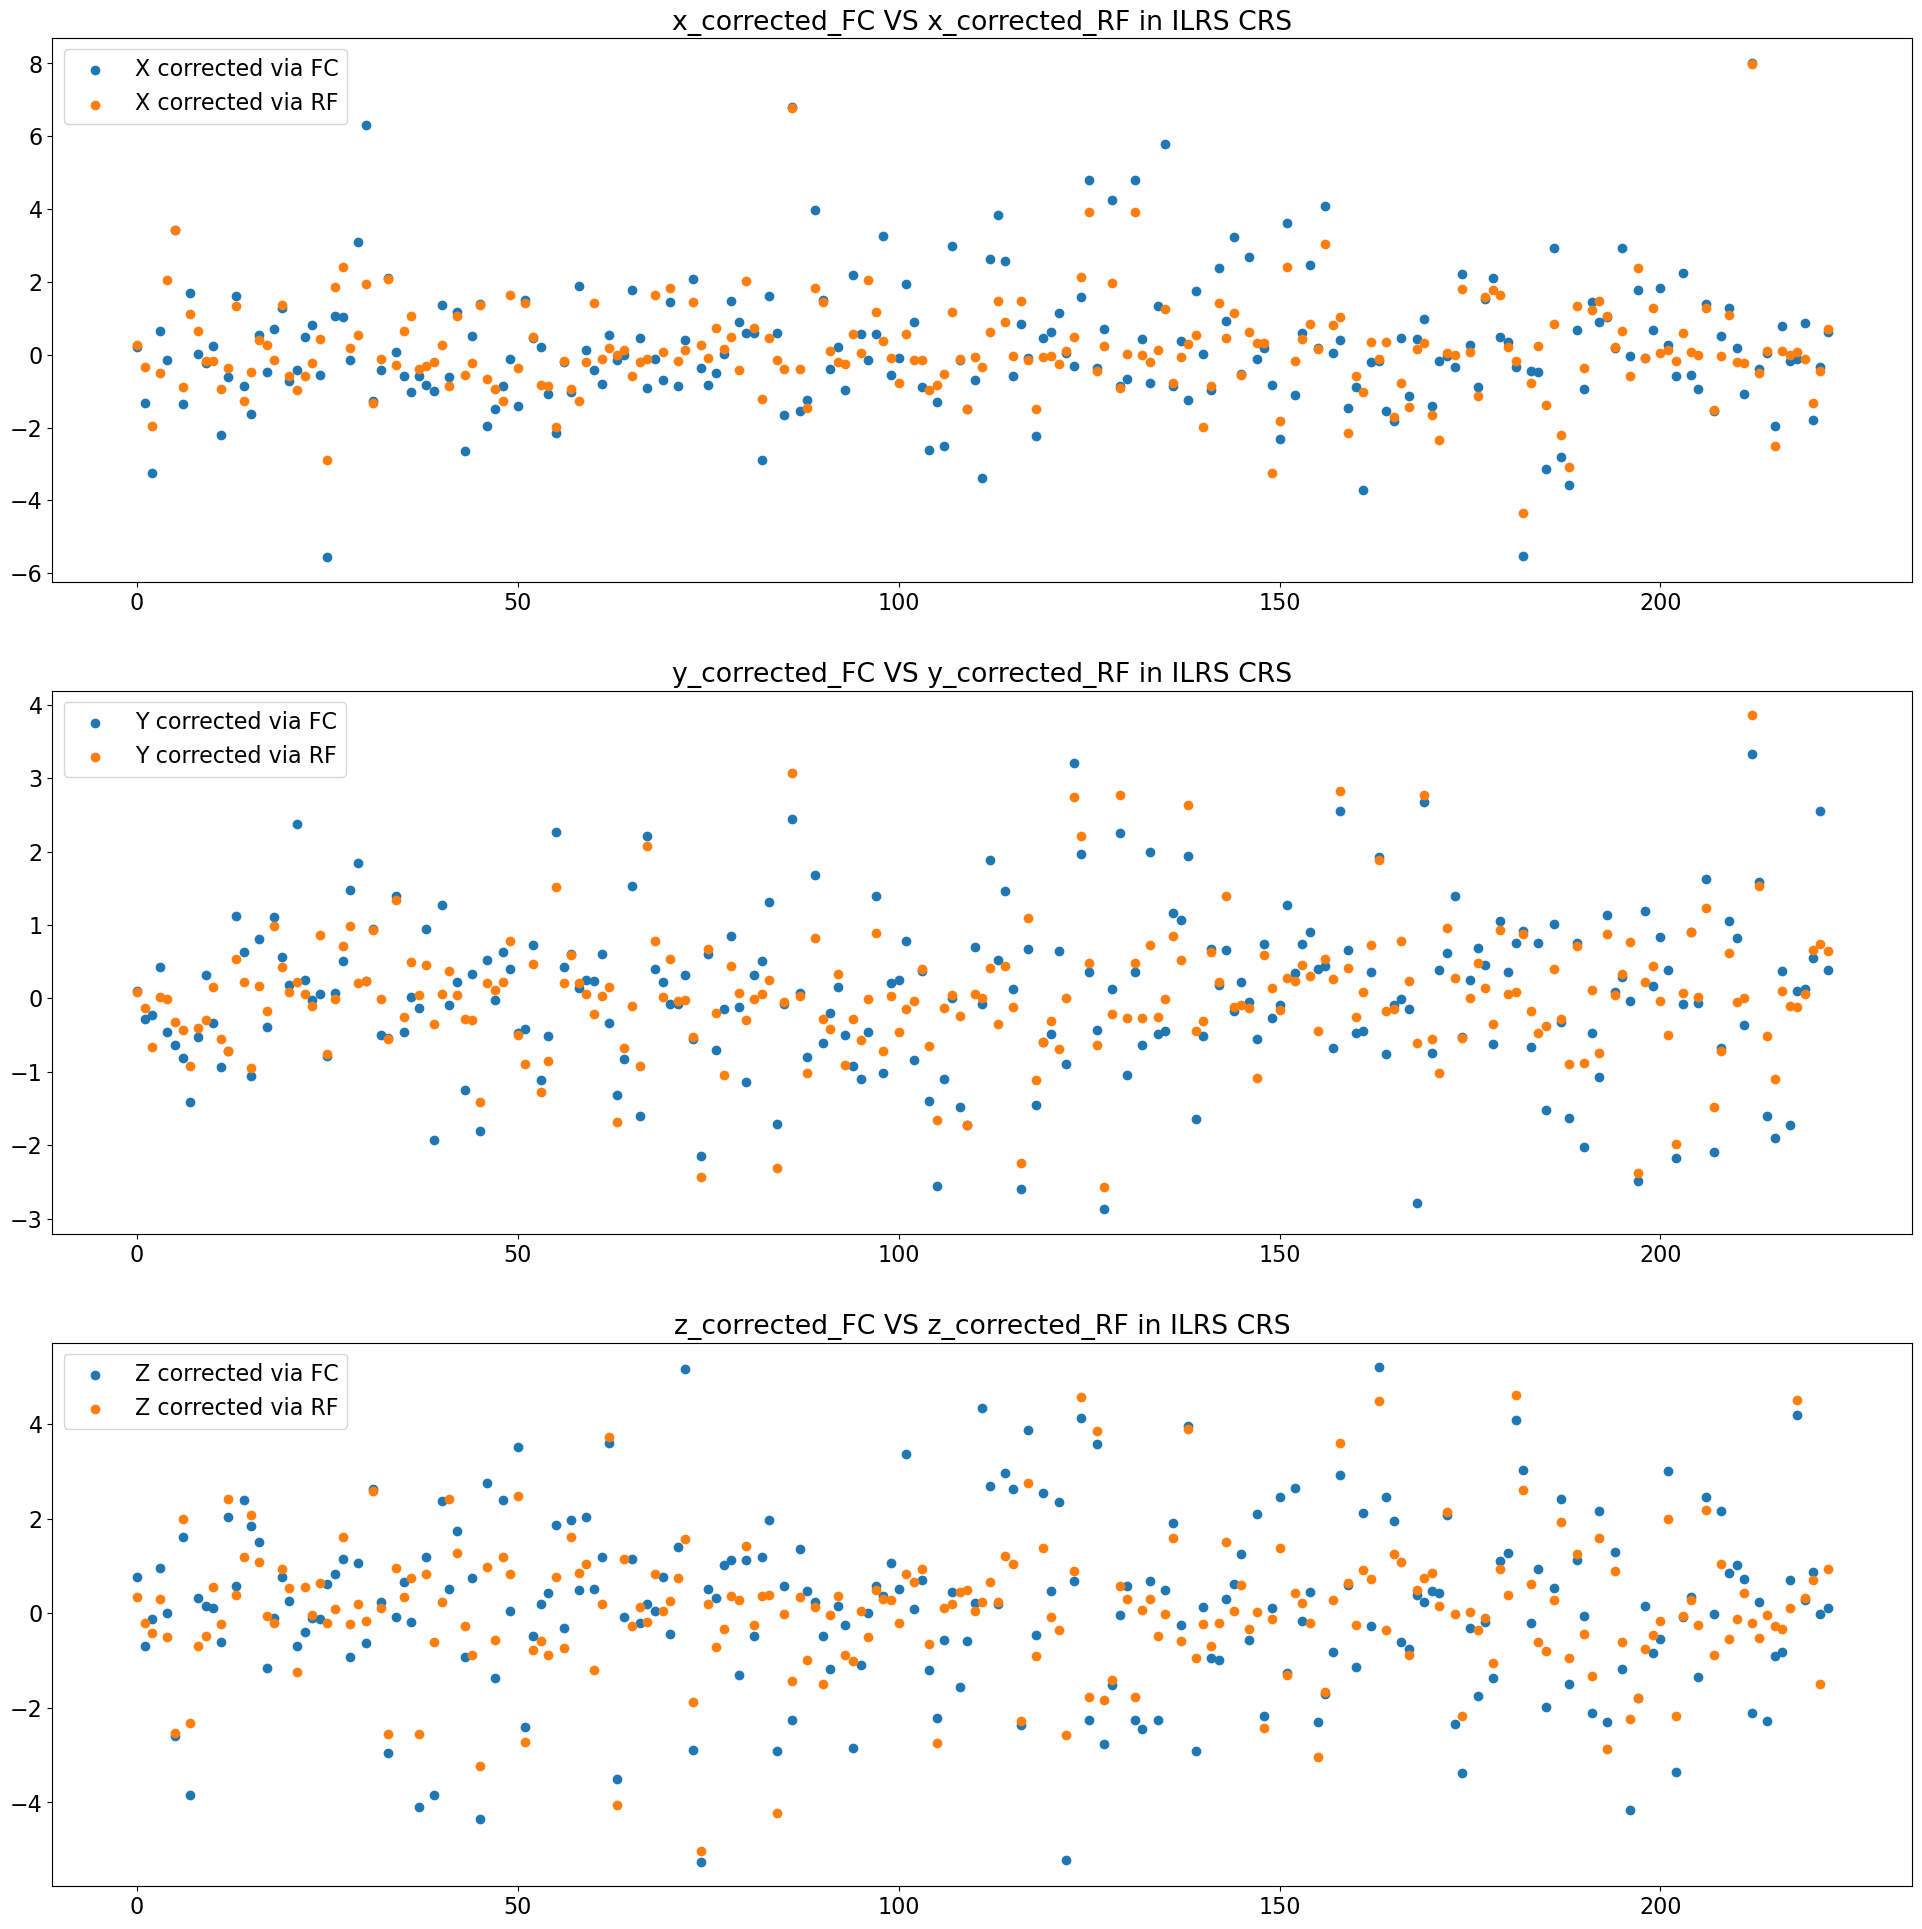

In [78]:
corrected_xyz_ilrs_csr = corrected_xyz-ilrs_xyz_inv[:,:3]
corrected_xyz_rf_ilrs_csr = corrected_xyz_rf-ilrs_xyz_inv[:,:3]
corrected_x_ilrs_csr,corrected_y_ilrs_csr,corrected_z_ilrs_csr = corrected_xyz_ilrs_csr[:,0],corrected_xyz_ilrs_csr[:,1],corrected_xyz_ilrs_csr[:,2]
correctedrf_x_ilrs_csr,correctedrf_y_ilrs_csr,correctedrf_z_ilrs_csr = corrected_xyz_rf_ilrs_csr[:,0],corrected_xyz_rf_ilrs_csr[:,1],corrected_xyz_rf_ilrs_csr[:,2]
sgp4_x, sgp4_y, sgp4_z = sgp4_xyz[:,0], sgp4_xyz[:,1], sgp4_xyz[:,2]
ilrs_x_inv,ilrs_y_inv,ilrs_z_inv = ilrs_xyz_inv[:,0],ilrs_xyz_inv[:,1],ilrs_xyz_inv[:,2]
fig, ax = plt.subplots(3,1, figsize=(24,24))
#X
ax[0].scatter(np.arange(len(corrected_x_ilrs_csr)),corrected_x_ilrs_csr, label='X corrected via FC')#false_clr)
ax[0].scatter(np.arange(len(correctedrf_x_ilrs_csr)),correctedrf_x_ilrs_csr, label='X corrected via RF')
#Y
ax[1].scatter(np.arange(len(corrected_x_ilrs_csr)),corrected_y_ilrs_csr, label='Y corrected via FC')#false_clr)
ax[1].scatter(np.arange(len(correctedrf_x_ilrs_csr)),correctedrf_y_ilrs_csr, label='Y corrected via RF')#false_clr)
#Z
ax[2].scatter(np.arange(len(corrected_x_ilrs_csr)),corrected_z_ilrs_csr, label='Z corrected via FC')#false_clr)
ax[2].scatter(np.arange(len(correctedrf_x_ilrs_csr)),correctedrf_z_ilrs_csr, label='Z corrected via RF')
#titles
ax[0].set_title('x_corrected_FC VS x_corrected_RF in ILRS CRS')
ax[1].set_title('y_corrected_FC VS y_corrected_RF in ILRS CRS')
ax[2].set_title('z_corrected_FC VS z_corrected_RF in ILRS CRS')
ax[0].legend()
ax[1].legend()
ax[2].legend()
plt.show()

### **PLOTTING THE ORBIT POINTS OF SATELLITE IN J2000**

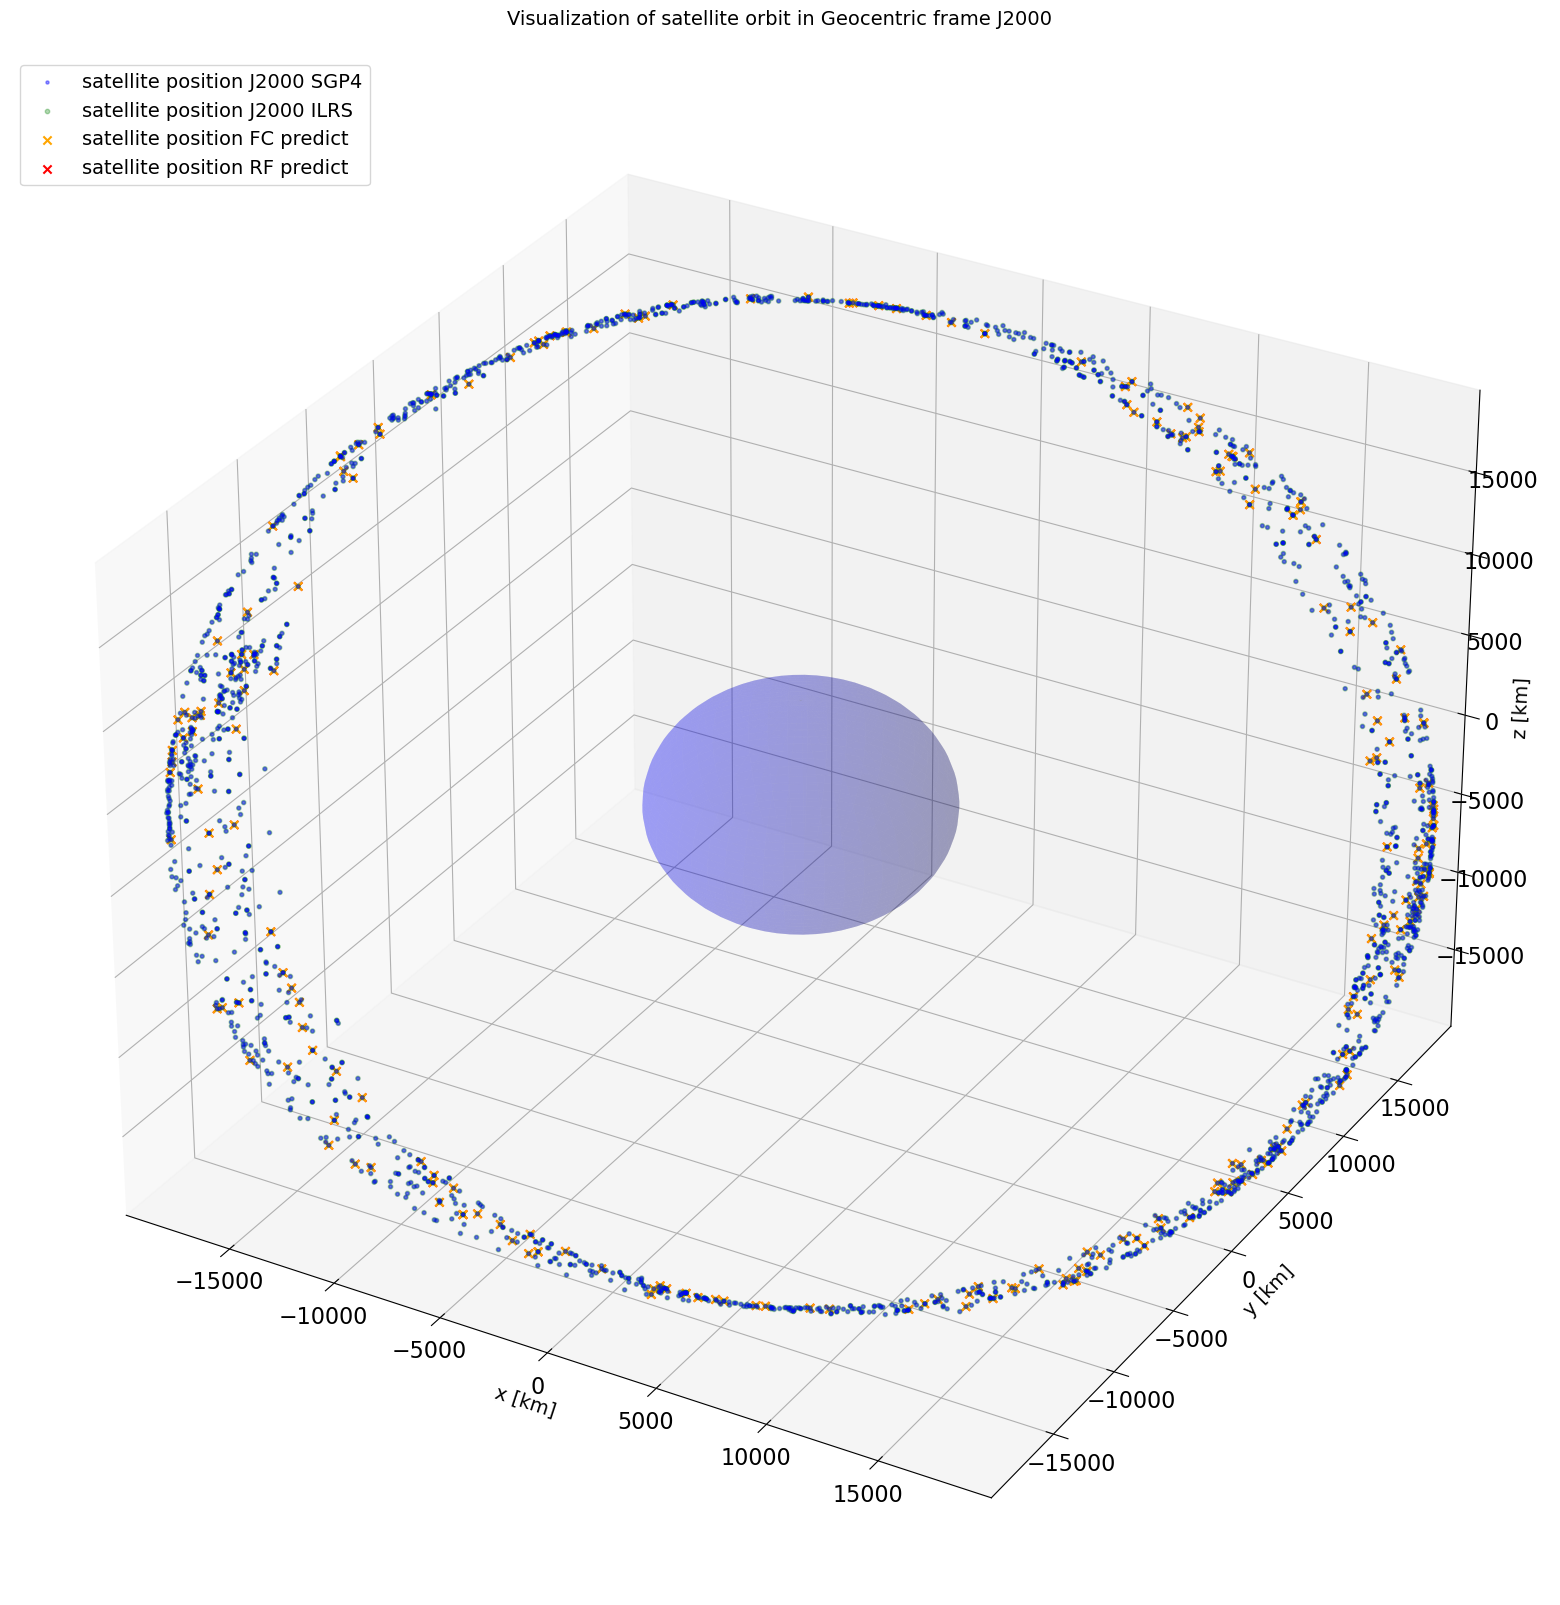

In [79]:
fig=plt.figure(figsize=(20,20))#Create 3D axes
ax = plt.axes(projection='3d')
plt.rcParams['font.size'] = '16'
r_Earth= 6400 #km
# making grid for Earth to visualize
NN = 50
phi = np.linspace(0, 2 * np.pi, NN)
theta = np.linspace(0, np.pi, NN)
theta, phi = np.meshgrid(theta, phi)
X_e = r_Earth * np.cos(phi) * np.sin(theta)
Y_e = r_Earth * np.sin(phi) * np.sin(theta)
Z_e = r_Earth * np.cos(theta)
# plotting Earth as a sphere wit radius of r_Earth
e_surf = ax.plot_surface(X_e, Y_e, Z_e, color='blue', alpha=0.2)
e_surf._facecolors2d = e_surf._facecolor3d
e_surf._edgecolors2d = e_surf._edgecolor3d
# plotting dynamics of earth LEO sat around Earth
ax.scatter(sgp4_coords['x_j2000_tle'],sgp4_coords['y_j2000_tle'],sgp4_coords['z_j2000_tle'],color="blue",marker="o",s=5,alpha=0.4,label="satellite position J2000 SGP4")
ax.scatter(ilrs_coords['x_j2000_ilrs_Akima'],ilrs_coords['y_j2000_ilrs_Akima'],ilrs_coords['z_j2000_ilrs_Akima'],color="green",s=10,alpha=0.3,label="satellite position J2000 ILRS")
ax.scatter(corrected_xyz[:,0],corrected_xyz[:,1],corrected_xyz[:,2],color="orange",marker="x",s=35,alpha=1,label="satellite position FC predict"  )
ax.scatter(corrected_xyz_rf[:,0],corrected_xyz_rf[:,1],corrected_xyz_rf[:,2],color="red",marker="x",s=35,alpha=1,label="satellite position RF predict"  )
# axis labeling
ax.set_xlabel("x [km]",fontsize=14)
ax.set_ylabel("y [km]",fontsize=14)
ax.set_zlabel("z [km]",fontsize=14)
ax.set_title("Visualization of satellite orbit in Geocentric frame J2000\n",fontsize=14)
ax.legend(loc="upper left",fontsize=14)

ax.set_xlim3d(-3.*r_Earth, 3.*r_Earth)
ax.set_ylim3d(-3.*r_Earth, 3.*r_Earth)
ax.set_zlim3d(-3.*r_Earth, 3.*r_Earth)
plt.show()

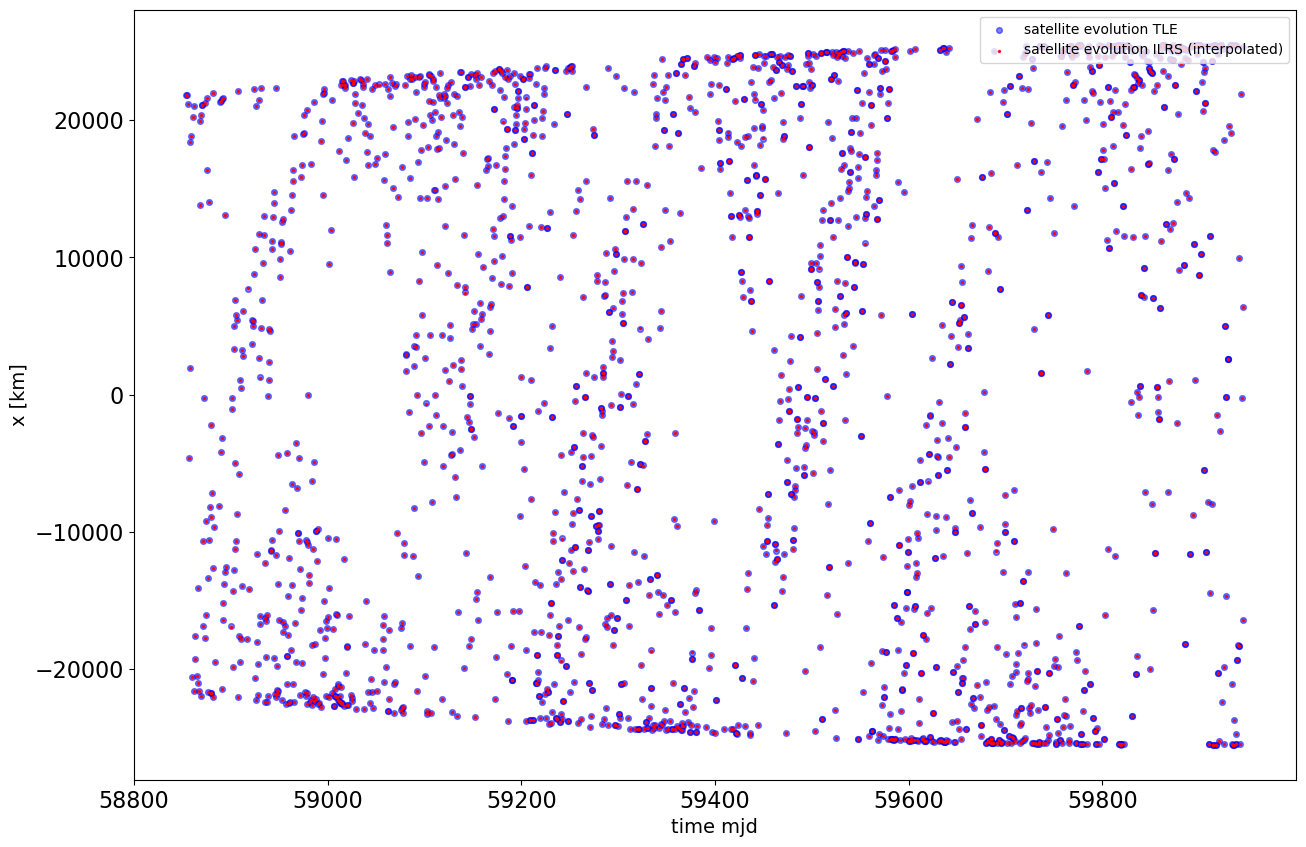

In [80]:
# x(t) axis
fig=plt.figure(figsize=(15,10))
plt.scatter(df_tle_ilrs['mjd_t'],sgp4_coords['x_j2000_tle'], s=17, color ='blue',alpha= 0.5, label ='satellite evolution TLE')
plt.scatter(df_tle_ilrs['mjd_t'],ilrs_coords['x_j2000_ilrs_Akima'], s=2,color ='red',alpha= 0.9, label ='satellite evolution ILRS (interpolated)')
plt.ylabel("x [km]",fontsize=14)
plt.xlabel("time mjd",fontsize=14)
plt.legend(loc="upper right",fontsize=10)
plt.show()

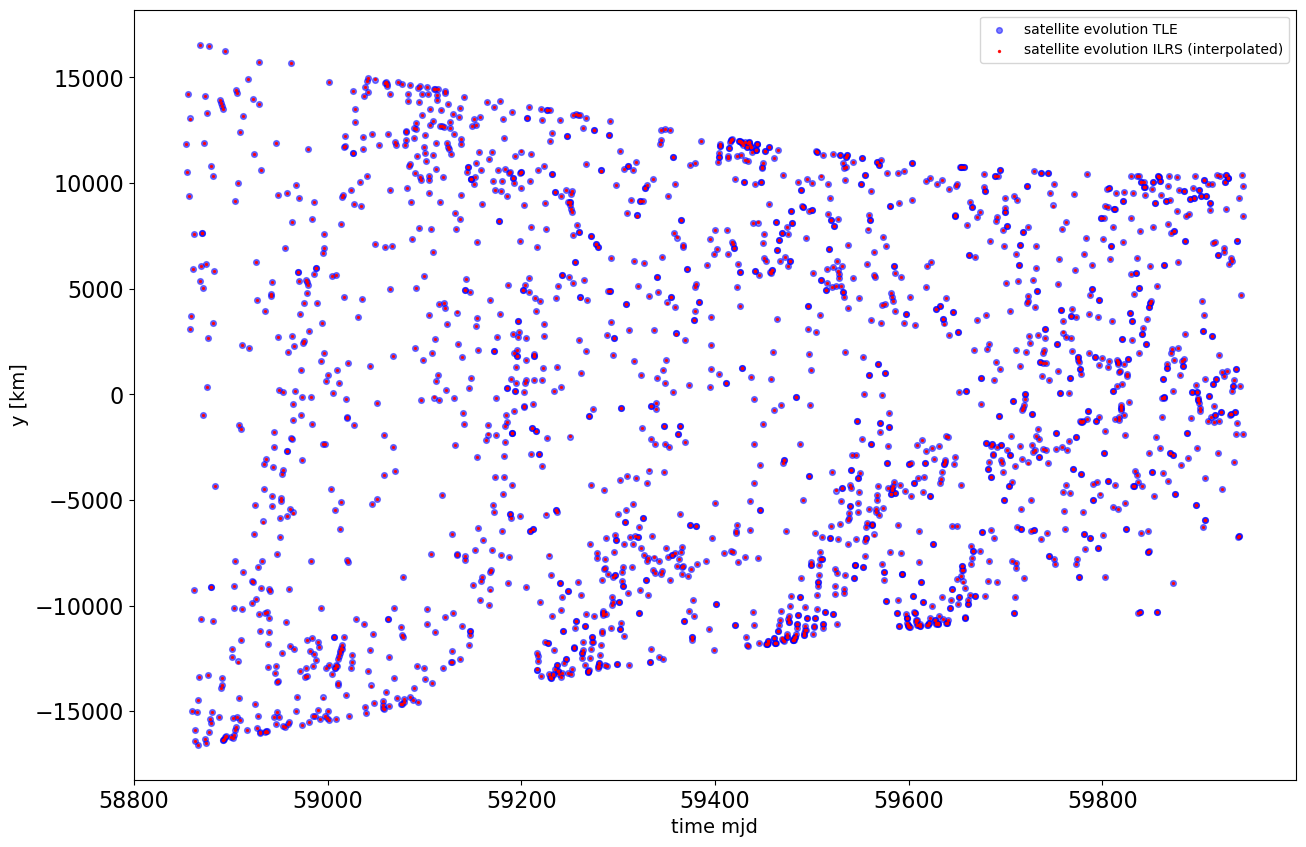

In [81]:
# y(t) axis
fig=plt.figure(figsize=(15,10))
plt.scatter(df_tle_ilrs['mjd_t'],sgp4_coords['y_j2000_tle'], s=17, color ='blue',alpha= 0.5, label ='satellite evolution TLE')
plt.scatter(df_tle_ilrs['mjd_t'],ilrs_coords['y_j2000_ilrs_Akima'], s=2,color ='red',alpha= 0.9, label ='satellite evolution ILRS (interpolated)')
plt.ylabel("y [km]",fontsize=14)
plt.xlabel("time mjd",fontsize=14)
plt.legend(loc="upper right",fontsize=10)
plt.show()

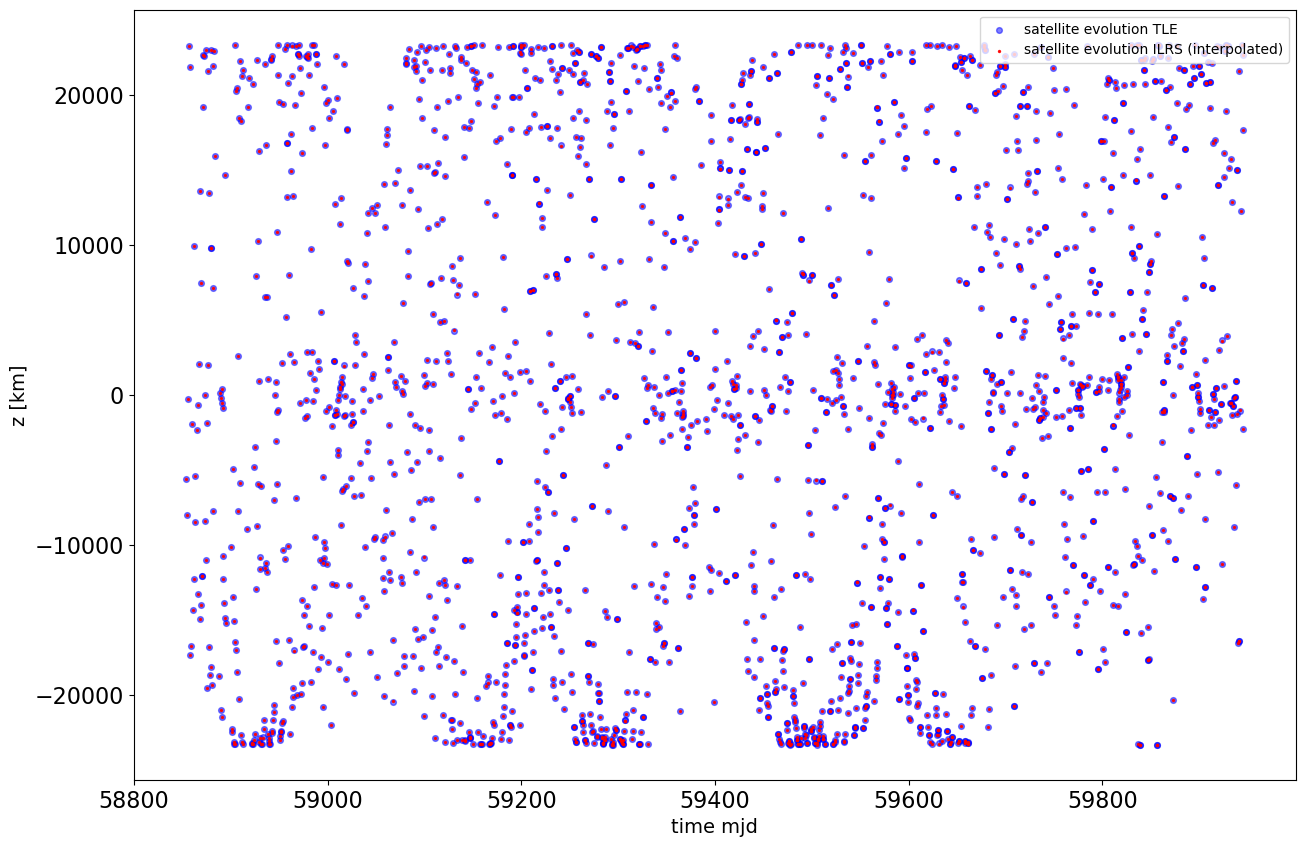

In [82]:
# z(t) axis
fig=plt.figure(figsize=(15,10))
plt.scatter(df_tle_ilrs['mjd_t'],sgp4_coords['z_j2000_tle'], s=17, color ='blue',alpha= 0.5, label ='satellite evolution TLE')
plt.scatter(df_tle_ilrs['mjd_t'],ilrs_coords['z_j2000_ilrs_Akima'], s=2,color ='red',alpha= 0.9, label ='satellite evolution ILRS (interpolated)')
plt.ylabel("z [km]",fontsize=14)
plt.xlabel("time mjd",fontsize=14)
plt.legend(loc="upper right",fontsize=10)
plt.show()